In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import ParamsPrep
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_Omicron_symp = Data_df[(Data_df.cat_Lineage7variants=='Omicron')*(Data_df.cat_SympEver!='No')]

IDs_Symp = Data_Omicron_symp.ID.unique()
print(len(IDs_Symp))

IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

822


In [5]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [6]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [7]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [12]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,LOD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**LOD))
          #  v[v==2]=1
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == LOD) & (t>Tmax))]

            while (len(PS_Duration) != 0 and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**LOD))
              #  v[v==2]=1
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == LOD) & (t>Tmax))]
    
    return params, param_dict

In [13]:
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 40 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [14]:
def StandardDoseTimeSim(Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,LOD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):
        

        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed[idi], MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        v = np.log10(np.maximum(V,10**LOD))
       # v[v==2]=1
        X.append(v)
        times.append(t)
    return X, times

In [17]:
# heatmap of rebound as a function of potency and timing of therapy
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
prf_mean = 40.33
prf_sd = 0.83 # sd of lognormal distribution
MolMass = 499.5 
Num = 400
LOD = 1.26
Cohort = Cohort_Prep(IDs_Symp, Num)
CohortStyle = 'direct'
rebound_prob2_dur = []
rebound_prob1_dur = []
rebound_prob05_dur = []
Median_drop_VL_mat_dur =[]
Median_VL_mat_dur =[]

for dur in [2, 5, 10, 15, 20]:
    print(dur)
    rebound2 = []
    rebound1 = []
    rebound05 = []
    drop_VL = []
    VL = []
    Median_drop_VL = []
    Median_VL = []
    for timing in ['PEP', 'Early Trtmnt', 'Trial', 'Late Trtmnt']: 
        Cohort = Cohort_Prep(IDs_Symp, Num)
        dose = 300
        PotRed=np.random.lognormal(mean = np.log(prf_mean), sigma = prf_sd, size = Num)
        VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
        VLparams, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort,np.ones(Num), VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, 0, SetInit, VLPKPD,LOD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)

        if timing == 'PEP':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
            for idi in range(0, Num):
                if (TrtmntStrtDay[idi]-param_dict[idi]['tzero']>0):
                    TrtmntStrtDay [idi] =  -param_dict[idi]['tzero']
                else:
                    TrtmntStrtDay [idi] =TrtmntStrtDay[idi]-param_dict[idi]['tzero']
        elif timing == 'Early Trtmnt':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
        elif timing =='Trial':
            TrtmntStrtDay = [random.randint(1, 5) for i in range(0,len(Cohort))]
        else:
            TrtmntStrtDay = [random.randint(5, 10) for i in range(0,len(Cohort))]

        X, times = StandardDoseTimeSim(Cohort,TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,LOD,
                                       TreatmentLength = dur, TreatmentFrequency = 0.5)
        L2 = np.zeros(len(X))
        L1 = np.zeros(len(X))
        L05 = np.zeros(len(X))
        for ii,(x,t) in enumerate(zip(X,times)):
        # -- flag rebound if increase of viral load by at least 2 log following end of treatment
            temp = np.argwhere(t>TrtmntStrtDay[ii]+dur)
            idx = temp[0][0]
            if (np.max(x[idx:])-x[idx])>2:
                L2[ii] = 1
            if (np.max(x[idx:])-x[idx])>1:
                L1[ii] = 1
            if (np.max(x[idx:])-x[idx])>0.5:
                L05[ii] = 1
            t_on = np.argwhere(t >= TrtmntStrtDay[ii])[0][0]#index of treatment start
            t_target = np.argwhere(t>=TrtmntStrtDay[ii]+dur)[0][0]
            drop_VL.append(x[t_target]-x[t_on])
            VL.append(x[t_target])
            
        Median_drop_VL.append(np.median(drop_VL, axis=0))
        Median_VL.append(np.median(VL, axis=0))
        rebound1.append((np.sum(L1)/Num)*100)
        rebound2.append((np.sum(L2)/Num)*100)
        rebound05.append((np.sum(L05)/Num)*100)
    rebound_prob2_dur.append(rebound2)
    rebound_prob1_dur.append(rebound1)
    rebound_prob05_dur.append(rebound05)
    Median_drop_VL_mat_dur.append(Median_drop_VL)
    Median_VL_mat_dur.append(Median_VL)

2
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3930415471099D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3408682381731D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3778542695147D+02   r2 =                  NaN
5
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3754426996413D+02   r2 =                  NaN
10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3477628235856D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf

In [18]:
pickle.dump(Median_VL_mat_dur , open('FigureData/VL_HeatMap_durtiming_rev1.pickle', 'wb'))
pickle.dump(Median_drop_VL_mat_dur, open('FigureData/dropVL_Median_HeatMap_durtiming_rev1.pickle', 'wb'))
pickle.dump(rebound_prob2_dur, open('FigureData/rebound05_HeatMap_durtiming_rev1.pickle', 'wb'))
pickle.dump(rebound_prob1_dur, open('FigureData/rebound1_HeatMap_durtiming_rev1.pickle', 'wb'))
pickle.dump(rebound_prob05_dur, open('FigureData/rebound2_HeatMap_durtiming_rev1.pickle', 'wb'))

[Text(0.5, 0, 'PEP'),
 Text(1.5, 0, 'Early'),
 Text(2.5, 0, 'Intermediate'),
 Text(3.5, 0, 'Late')]

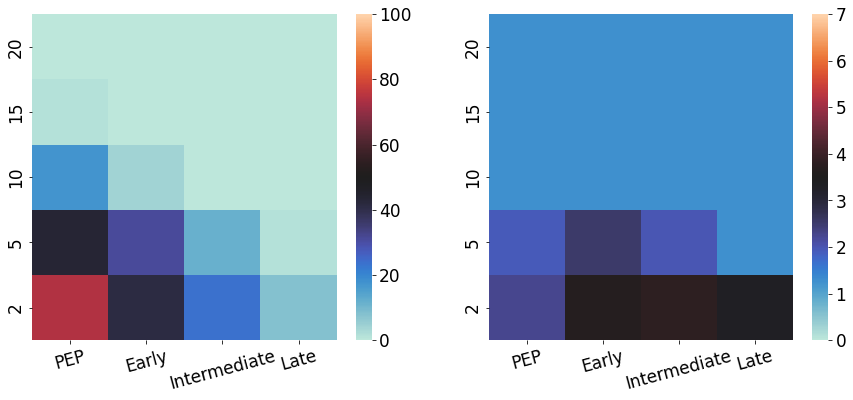

In [20]:
fig = plt.figure(figsize = (15,6))
plt.rcParams.update({'font.size': 17})
ylabels = [2, 5, 10, 15, 20]
plt.subplot(1,2,1)
ax = sns.heatmap(rebound_prob1_dur, vmin =0, vmax = 100, annot = False, fmt = '.1f', 
                  yticklabels = ylabels, xticklabels = ['PEP', 'Early', 'Intermediate', 'Late'],
                  cmap = "icefire")
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
#plt.ylabel('Treatment Duration')
#plt.xlabel('Timing of Treatment')
#fig.text(0.45, 1, 'rebound \n probability (%)', 
      #   ha='center', va='center', size = '15')
plt.subplot(1,2,2)
ax = sns.heatmap(Median_VL_mat_dur, vmin =0, vmax = 7, cmap = 'icefire', 
                 annot = False, fmt = '.1f', yticklabels = ylabels, 
                 xticklabels = ['PEP', 'Early', 'Intermediate', 'Late'],
                 )
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
#fig.text(0.85, 1, 'log10 viral load \n at the end of treatment ', 
    #     ha='center', va='center', size = '15')
#plt.ylabel('Treatment Duration')
#plt.xlabel('Timing of Treatment')
#plt.savefig('PaperFigs/dur-timingHeatmaps_1log.svg')
#plt.savefig('PaperFigs/dur-timingHeatmaps_1log.png')